# Regression Model for Kaggle Tabular Playground Series February 2021 Using TensorFlow Decision Forests
### David Lowe
### November 19, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Series Aug 2021 dataset is a regression situation where we are trying to predict the value of a continuous variable.

Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The February dataset may be synthetic but is based on a real dataset and generated using a CTGAN. The original dataset tries to predict the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The performance of the preliminary Random Forest model achieved an RMSE benchmark of 0.8422 on the validation dataset. The final model processed the validation dataset with a final RMSE score of 0.8549. When we applied the finalized model to Kaggle's test dataset, the model achieved an RMSE score of 0.8534.

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground Series Aug 2021 Data Set

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-feb-2021

One potential source of performance benchmarks: https://www.kaggle.com/c/tabular-playground-series-feb-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Train and Evaluate Models
4. Fine-tune and Improve Models
5. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [ ]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL
!pip install tensorflow_decision_forests

In [ ]:
!pip install wurlitzer

In [ ]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [ ]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [ ]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [ ]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
import tensorflow_decision_forests as tfdf

In [ ]:
try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

### 1.b) Set up the controlling parameters and functions

In [ ]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'mean_squared_error'
DEFAULT_METRICS = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
MAX_EPOCHS = 10
BATCH_SIZE = 32

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Num GPUs Available: 0
TensorFlow version: 2.7.0
Found TensorFlow Decision Forests v0.2.1


In [ ]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [ ]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [ ]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [ ]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021feb/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id cat0 cat1 cat2 cat3  ...    cont10    cont11    cont12    cont13    target
0   1    A    B    A    A  ...  0.724417  0.701915  0.877618  0.719903  6.994023
1   2    B    A    A    A  ...  0.613252  0.741289  0.326679  0.808464  8.071256
2   3    A    A    A    C  ...  0.264104  0.695561  0.869133  0.828352  5.760456
3   4    A    A    A    C  ...  0.494269  0.698125  0.809799  0.614766  7.806457
4   6    A    B    A    A  ...  0.724447  0.683073  0.343457  0.297743  6.868974

[5 rows x 26 columns]


In [ ]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cont0   300000 non-null  float64
 12  cont1   300000 non-null  float64
 13  cont2   300000 non-null  float64
 14  cont3   300000 non-null  float64
 15  cont4   300000 non-null  float64
 16  cont5   300000 non-null  float64
 17  cont6   300000 non-null  float64
 18  cont7   300000 non-null  float64
 19  cont8   300000 non-null  float64
 20  cont9   300000 non-null  float64
 21  cont10  30

In [ ]:
print(df_dataset_import.describe())

                  id          cont0  ...         cont13         target
count  300000.000000  300000.000000  ...  300000.000000  300000.000000
mean   250018.576947       0.524634  ...       0.503349       7.456260
std    144450.150010       0.204875  ...       0.225218       0.887295
min         1.000000      -0.093505  ...       0.158121       0.000000
25%    124772.500000       0.370451  ...       0.291289       6.798341
50%    250002.500000       0.492208  ...       0.433909       7.496503
75%    375226.500000       0.654793  ...       0.730870       8.161166
max    499999.000000       1.052666  ...       0.873579      10.309208

[8 rows x 16 columns]


In [ ]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [ ]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

  cat0 cat1 cat2 cat3 cat4  ...    cont10    cont11    cont12    cont13    target
0    A    B    A    A    B  ...  0.724417  0.701915  0.877618  0.719903  6.994023
1    B    A    A    A    B  ...  0.613252  0.741289  0.326679  0.808464  8.071256
2    A    A    A    C    B  ...  0.264104  0.695561  0.869133  0.828352  5.760456
3    A    A    A    C    B  ...  0.494269  0.698125  0.809799  0.614766  7.806457
4    A    B    A    A    B  ...  0.724447  0.683073  0.343457  0.297743  6.868974

[5 rows x 25 columns]


In [ ]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

In [ ]:
print(df_dataset_import.describe())

               cont0          cont1  ...         cont13         target
count  300000.000000  300000.000000  ...  300000.000000  300000.000000
mean        0.524634       0.506649  ...       0.503349       7.456260
std         0.204875       0.235269  ...       0.225218       0.887295
min        -0.093505      -0.055105  ...       0.158121       0.000000
25%         0.370451       0.352307  ...       0.291289       6.798341
50%         0.492208       0.615156  ...       0.433909       7.496503
75%         0.654793       0.688150  ...       0.730870       8.161166
max         1.052666       0.851746  ...       0.873579      10.309208

[8 rows x 15 columns]


In [ ]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [ ]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (300000, 25) df_features_train.shape: (300000, 24) df_target_train.shape: (300000,)


### 1.f) Set up the parameters for data visualization

In [ ]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [ ]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [ ]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

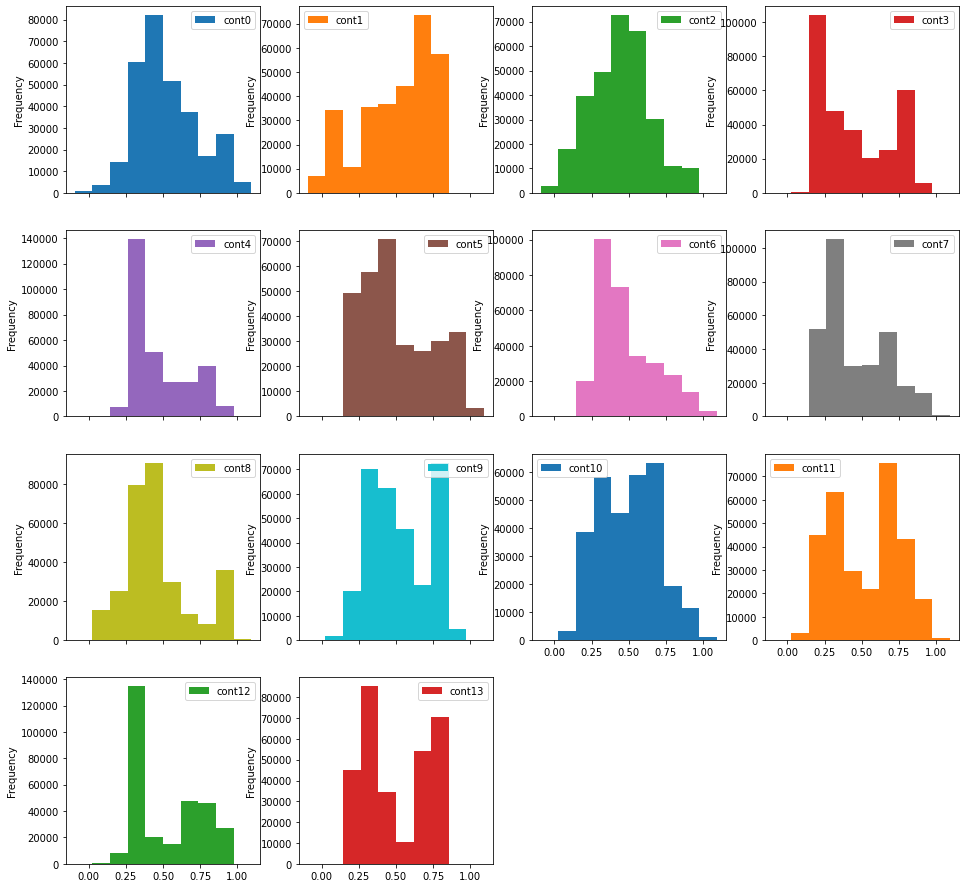

In [ ]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

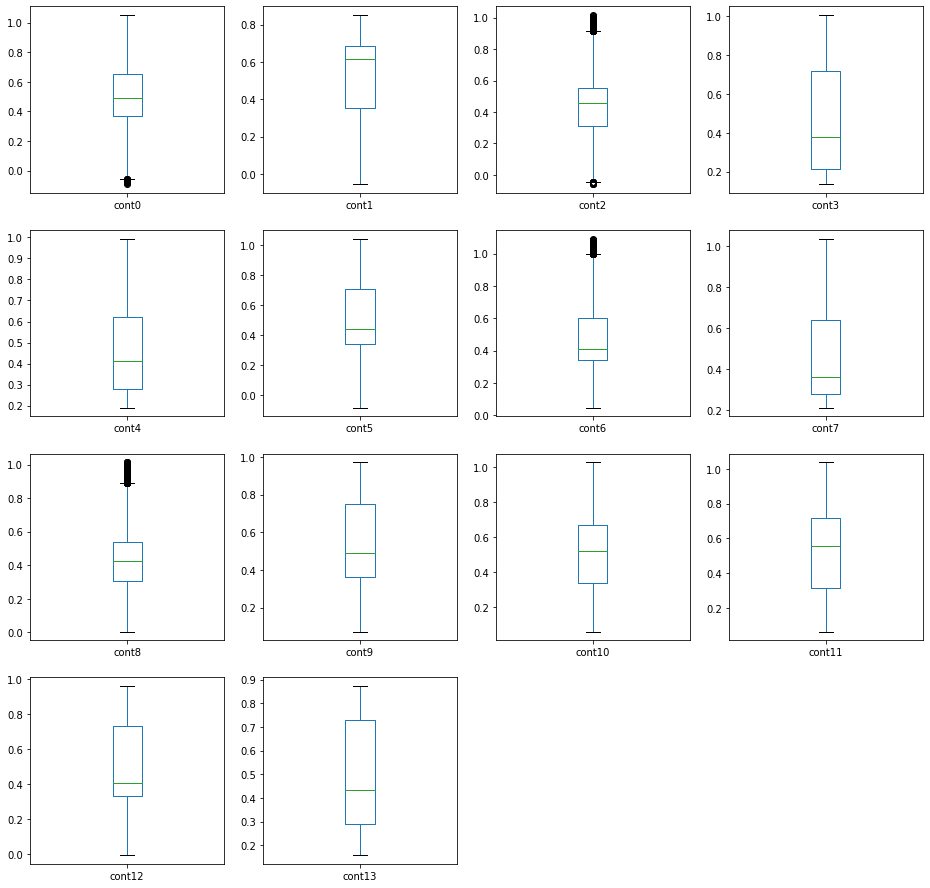

In [ ]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

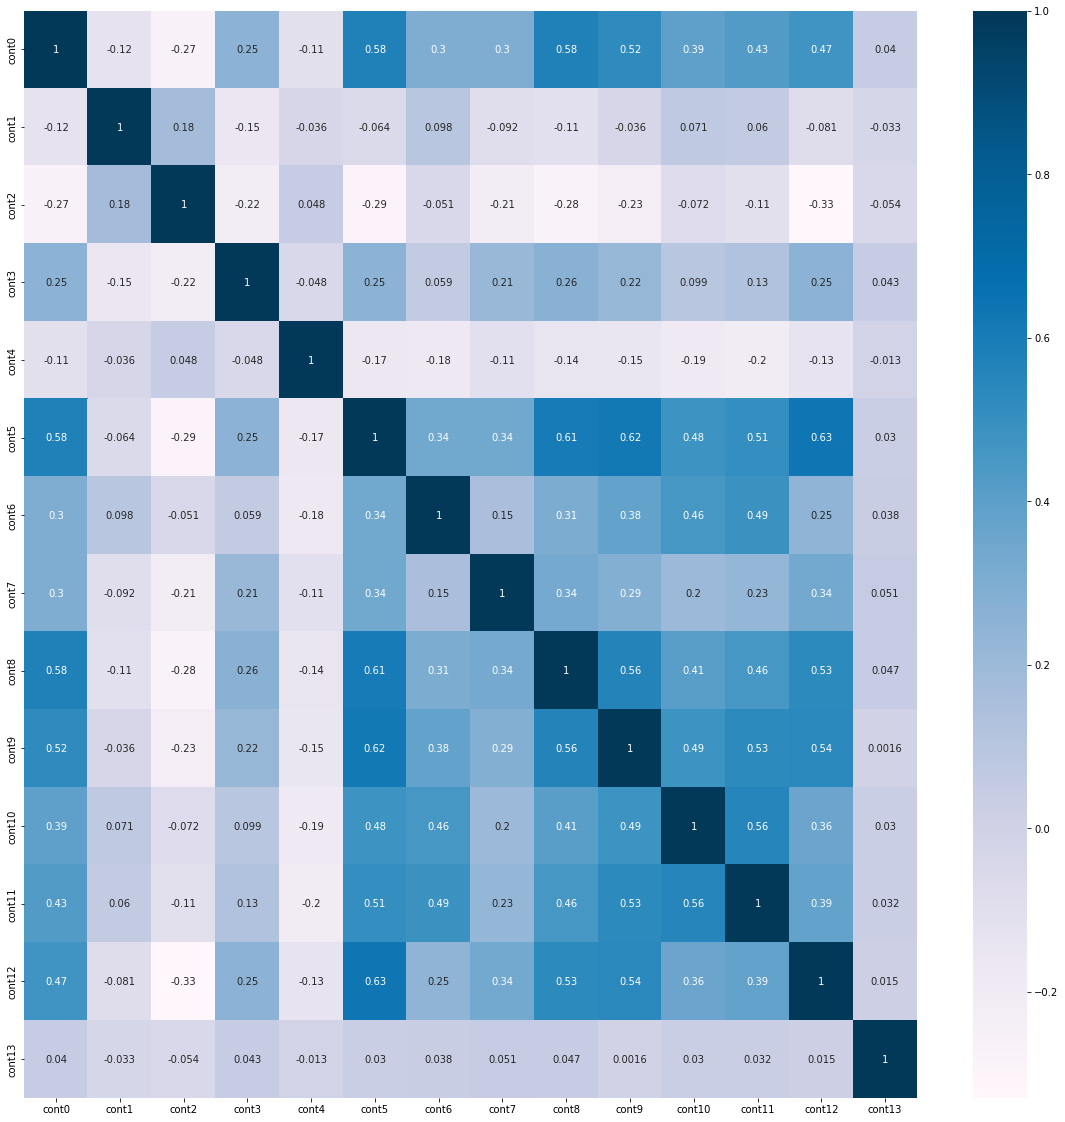

In [ ]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [ ]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [ ]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [ ]:
# Split the data further into training and validation datasets
df_dataset_train, df_dataset_valid = train_test_split(df_dataset_import, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
print("df_dataset_train.shape: {} df_dataset_valid.shape: {}".format(df_dataset_train.shape, df_dataset_valid.shape))

df_dataset_train.shape: (270000, 25) df_dataset_valid.shape: (30000, 25)


In [ ]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task = tfdf.keras.Task.REGRESSION)
tfds_valid = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_valid, label='target', task = tfdf.keras.Task.REGRESSION)

### 3.b) Train and Evaluate the Random Forest Model

In [ ]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
model_1 = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

# Optionally, add evaluation metrics.
model_1.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_1.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

4218/4219 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4219
[INFO kernel.cc:393] Number of examples: 270000
[INFO data_spec_inference.cc:290] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat6 (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:290] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat7 (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 270000
Number of columns: 25

Number of columns by type:
	NUMERICAL: 15 (60%)
	CATEGORICAL: 10 (40%)

Columns:

NUMERICAL: 15 (60%)
	10: "cont0" NUMERICAL mean:0.524665 min:-0.0935054 max:1.05267 sd:0.204975
	11: "cont1" NUMERICAL mean:0.5066 min:-0.0551051 max:0.851746 sd:0.235212
	12: "cont10" NUMERICAL mean:0.504882 min:0.0596438 max:1.02977 

4219/4219 [==============================] - 591s 138ms/step
Model training time: 0:09:54.299498 



In [ ]:
tfdf.model_plotter.plot_model_in_colab(model_1)

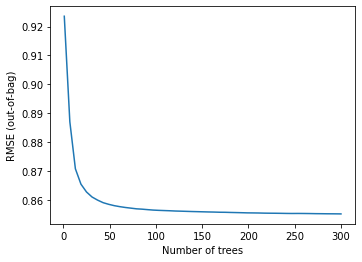

In [ ]:
logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")

plt.show()

In [ ]:
evaluation = model_1.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

469/469 [==============================] - 9s 18ms/step - loss: 0.0000e+00 - rmse: 0.8422

loss: 0.0000
rmse: 0.8422


### 3.c) Train and Evaluate the Decision Trees Model

In [ ]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
model_2 = tfdf.keras.CartModel(task = tfdf.keras.Task.REGRESSION)

# Optionally, add evaluation metrics.
model_2.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_2.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

4214/4219 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4219
[INFO kernel.cc:393] Number of examples: 270000
[INFO data_spec_inference.cc:290] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat6 (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:290] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat7 (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 270000
Number of columns: 25

Number of columns by type:
	NUMERICAL: 15 (60%)
	CATEGORICAL: 10 (40%)

Columns:

NUMERICAL: 15 (60%)
	10: "cont0" NUMERICAL mean:0.524665 min:-0.0935054 max:1.05267 sd:0.204975
	11: "cont1" NUMERICAL mean:0.5066 min:-0.0551051 max:0.851746 sd:0.235212
	12: "cont10" NUMERICAL mean:0.504882 min:0.0596438 max:1.02977 

4219/4219 [==============================] - 23s 5ms/step
Model training time: 0:00:23.496514 



In [ ]:
tfdf.model_plotter.plot_model_in_colab(model_2)

In [ ]:
evaluation = model_2.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

469/469 [==============================] - 2s 4ms/step - loss: 0.0000e+00 - rmse: 5.3448

loss: 0.0000
rmse: 5.3448


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [ ]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
model_3 = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

# Optionally, add evaluation metrics.
model_3.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_3.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

4217/4219 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4219
[INFO kernel.cc:393] Number of examples: 270000
[INFO data_spec_inference.cc:290] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat6 (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:290] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat7 (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 270000
Number of columns: 25

Number of columns by type:
	NUMERICAL: 15 (60%)
	CATEGORICAL: 10 (40%)

Columns:

NUMERICAL: 15 (60%)
	10: "cont0" NUMERICAL mean:0.524665 min:-0.0935054 max:1.05267 sd:0.204975
	11: "cont1" NUMERICAL mean:0.5066 min:-0.0551051 max:0.851746 sd:0.235212
	12: "cont10" NUMERICAL mean:0.504882 min:0.0596438 max:1.02977 

4219/4219 [==============================] - 283s 67ms/step
Model training time: 0:04:43.521591 



In [ ]:
tfdf.model_plotter.plot_model_in_colab(model_3)

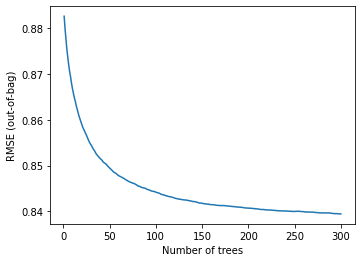

In [ ]:
logs = model_3.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")

plt.show()

In [ ]:
evaluation = model_3.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

469/469 [==============================] - 2s 5ms/step - loss: 0.0000e+00 - rmse: 4.3905

loss: 0.0000
rmse: 4.3905


In [ ]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [ ]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [ ]:
for num_trees in [300, 500, 750, 1000]:
    # Define the baseline model for benchmarking
    start_time_module = datetime.now()
    reset_random()
    model_tune = tfdf.keras.RandomForestModel(num_trees=num_trees,
                                              task = tfdf.keras.Task.REGRESSION)

    # Optionally, add evaluation metrics.
    model_tune.compile(metrics=DEFAULT_METRICS)

    # Train the model.
    model_tune.fit(x=tfds_train, verbose=False)

    evaluation = model_tune.evaluate(tfds_valid, return_dict=True)
    print()

    for name, value in evaluation.items():
        print(f"{name}: {value:.4f}")
    print ('Model optimization time:', (datetime.now() - start_time_module), '\n')

469/469 [==============================] - 8s 16ms/step - loss: 0.0000e+00 - rmse: 3.8256

loss: 0.0000
rmse: 3.8256
Model optimization time: 0:09:36.504236 



469/469 [==============================] - 14s 29ms/step - loss: 0.0000e+00 - rmse: 3.4423

loss: 0.0000
rmse: 3.4423
Model optimization time: 0:15:42.165996 



469/469 [==============================] - 24s 51ms/step - loss: 0.0000e+00 - rmse: 3.1612

loss: 0.0000
rmse: 3.1612
Model optimization time: 0:24:00.125419 

469/469 [==============================] - 23s 49ms/step - loss: 0.0000e+00 - rmse: 2.9439

loss: 0.0000
rmse: 2.9439
Model optimization time: 0:30:45.839464 



In [ ]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [ ]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [ ]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
final_model = tfdf.keras.RandomForestModel(num_trees=1000,
                                           task = tfdf.keras.Task.REGRESSION)

# Optionally, add evaluation metrics.
final_model.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

4209/4219 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4219
[INFO kernel.cc:393] Number of examples: 270000
[INFO data_spec_inference.cc:290] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat6 (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:290] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat7 (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 270000
Number of columns: 25

Number of columns by type:
	NUMERICAL: 15 (60%)
	CATEGORICAL: 10 (40%)

Columns:

NUMERICAL: 15 (60%)
	10: "cont0" NUMERICAL mean:0.524665 min:-0.0935054 max:1.05267 sd:0.204975
	11: "cont1" NUMERICAL mean:0.5066 min:-0.0551051 max:0.851746 sd:0.235212
	12: "cont10" NUMERICAL mean:0.504882 min:0.0596438 max:1.02977 

4219/4219 [==============================] - 2075s 492ms/step
Model training time: 0:35:23.505185 



In [ ]:
final_model.summary()

In [ ]:
tfdf.model_plotter.plot_model_in_colab(final_model)

In [ ]:
evaluation = final_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

### 5.b) Load Test Dataset and Prepare the Submission File

In [ ]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021feb/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   id cat0 cat1 cat2 cat3  ...     cont9    cont10    cont11    cont12    cont13
0   0    A    B    A    C  ...  0.242654  0.285147  0.264308  0.653654  0.302448
1   5    A    B    A    C  ...  0.516393  0.562065  0.730542  0.318492  0.736251
2  15    A    B    A    C  ...  0.548555  0.836193  0.759788  0.333572  0.273905
3  16    A    A    B    A  ...  0.596746  0.414131  0.255382  0.589080  0.311625
4  17    A    B    A    A  ...  0.263235  0.710961  0.224045  0.285860  0.794931

[5 rows x 25 columns]


In [ ]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

In [ ]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

In [ ]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_features_test, task = tfdf.keras.Task.REGRESSION)

In [ ]:
# Make batched predictions
test_predictions = final_model.predict(tfds_test)
print(test_predictions)

[[7.5870533]
 [7.7414684]
 [7.6116037]
 ...
 [7.399528 ]
 [7.4658513]
 [7.398456 ]]


In [ ]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

In [ ]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

In [ ]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [ ]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 2:14:26.181587
Total time for the script: 2:14:26.181587
